In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import matplotlib.ticker as mticker
from sksurv.tree import SurvivalTree
from sklearn.metrics import make_scorer
from sklearn.tree import plot_tree

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [5]:
# select features
X_surv_train = df_train.drop(columns=['TIMETOEVENT', 'MORTSTAT'])
X_surv_test = df_test.drop(columns=['TIMETOEVENT', 'MORTSTAT'])
# select target
y_surv_train = np.array([(event, time) for event, time in zip(df_train['MORTSTAT'], df_train['TIMETOEVENT'])], dtype=[('MORTSTAT', bool), ('TIMETOEVENT', float)])
y_surv_test = np.array([(event, time) for event, time in zip(df_test['MORTSTAT'], df_test['TIMETOEVENT'])], dtype=[('MORTSTAT', bool), ('TIMETOEVENT', float)])

In [6]:
# define scorer

In [7]:
def ll3y(estimator, X, y):
    event_indicators = np.where((y["MORTSTAT"] == 1) & (y["TIMETOEVENT"] <= 3), 0, 1)

    # Get predicted survival functions
    surv_funcs = estimator.predict_survival_function(X)

    # Get time points (assuming all survival functions have same time grid)
    time_points = surv_funcs[0].x

    # Extract survival probabilities at 3 years
    surv_prob_3y = np.array([fn(time_points[3]) for fn in surv_funcs])

    # Compute log-loss
    logloss = log_loss(event_indicators, surv_prob_3y)

    return -logloss  

In [8]:
# SurvTree

In [9]:
# ST1

In [10]:
param_grid_st1 = {'max_depth': [2, 3, 4, 5, 6]}

grid_search_st1 = GridSearchCV(estimator=SurvivalTree(), param_grid=param_grid_st1, scoring=ll3y, cv=4)

grid_search_st1.fit(X_surv_train, y_surv_train)
print(grid_search_st1.best_params_)

{'max_depth': 4}


In [11]:
# fit
st1 = SurvivalTree(max_depth=4)

start_time = time.time()
st1.fit(X_surv_train, y_surv_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 1.00 seconds


In [12]:
# predict survival function
surv_probs_train = st1.predict_survival_function(X_surv_train)
surv_probs_test = st1.predict_survival_function(X_surv_test)

# all time-to-event points
time_points_train = surv_probs_train[0].x
time_points_test = surv_probs_test[0].x 
 
# convert survival probabilities to df
df_surv_probs_train = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_train],  
    columns=time_points_train)
df_surv_probs_test = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_test],  
    columns=time_points_train)

# surv probabilites after 1 and 3 years
suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

# extract status
# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

# log-loss
log_loss_3y_train = log_loss(status_3y_train_surv, suvr_prob_3y_train)
log_loss_3y_test = log_loss(status_3y_test_surv, suvr_prob_3y_test)

# compute Brier
bs_train_3y = brier_score_loss(status_3y_train_surv, suvr_prob_3y_train)
bs_test_3y = brier_score_loss(status_3y_test_surv, suvr_prob_3y_test)

# c-index
c_is = concordance_index(status_3y_train_surv, suvr_prob_3y_train)

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1213
Log Loss os: 0.1210
BS is: 0.0310
BS os: 0.0306
C is: 0.8523


In [13]:
# ST2
param_grid_st2 = {'max_depth': [3, 4, 5, 6, 7],
                  'min_samples_split': [100, 200, 300, 400],
                  'max_leaf_nodes': [15, 20, 25, 30, 35, 40]}

grid_search_st2 = GridSearchCV(estimator=SurvivalTree(), param_grid=param_grid_st2, scoring=ll3y, cv=4, n_jobs=-1, verbose=1)

grid_search_st2.fit(X_surv_train, y_surv_train)
print(grid_search_st2.best_params_)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
{'max_depth': 7, 'max_leaf_nodes': 25, 'min_samples_split': 300}


In [14]:
# fit
st2 = SurvivalTree(max_depth=7, max_leaf_nodes=25, min_samples_split=300)

start_time = time.time()
st2.fit(X_surv_train, y_surv_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 1.63 seconds


In [15]:
# predict survival function
surv_probs_train = st2.predict_survival_function(X_surv_train)
surv_probs_test = st2.predict_survival_function(X_surv_test)

# all time-to-event points
time_points_train = surv_probs_train[0].x
time_points_test = surv_probs_test[0].x 
 
# convert survival probabilities to df
df_surv_probs_train = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_train],  
    columns=time_points_train)
df_surv_probs_test = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_test],  
    columns=time_points_train)

# surv probabilites after 1 and 3 years
suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

# extract status
status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

# log-loss
log_loss_3y_train = log_loss(status_3y_train_surv, suvr_prob_3y_train)
log_loss_3y_test = log_loss(status_3y_test_surv, suvr_prob_3y_test)

# compute Brier
bs_train_3y = brier_score_loss(status_3y_train_surv, suvr_prob_3y_train)
bs_test_3y = brier_score_loss(status_3y_test_surv, suvr_prob_3y_test)

# c-index
c_is = concordance_index(status_3y_train_surv, suvr_prob_3y_train)

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1188
Log Loss os: 0.1165
BS is: 0.0309
BS os: 0.0304
C is: 0.8675


In [16]:
# ST3

In [17]:
max_leaf_nodess = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

ll_is_st3 = []
ll_os_st3 = []
bs_is_st3 = []
bs_os_st3 = []

status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

for max_leaf_nodes in max_leaf_nodess:
    model = SurvivalTree(max_depth=7, max_leaf_nodes=max_leaf_nodes, min_samples_split = 300)
    model.fit(X_surv_train, y_surv_train)
    
    # get predicted probabilities
    surv_probs_train = model.predict_survival_function(X_surv_train)
    surv_probs_test = model.predict_survival_function(X_surv_test)
    # all time-to-event points
    time_points_train = surv_probs_train[0].x
    time_points_test = surv_probs_test[0].x 
    # convert survival probabilities to df
    df_surv_probs_train = pd.DataFrame(data=[fn(time_points_train) for fn in surv_probs_train],columns=time_points_train)
    df_surv_probs_test = pd.DataFrame(data=[fn(time_points_train) for fn in surv_probs_test], columns=time_points_train)
    # surv probabilites after 3 years
    suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
    suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

    # compute Log Loss
    ll_is_st3.append(log_loss(status_3y_train_surv, suvr_prob_3y_train))
    ll_os_st3.append(log_loss(status_3y_test_surv, suvr_prob_3y_test))
    # compute Brier
    bs_is_st3.append(brier_score_loss(status_3y_train_surv, suvr_prob_3y_train))
    bs_os_st3.append(brier_score_loss(status_3y_test_surv, suvr_prob_3y_test))

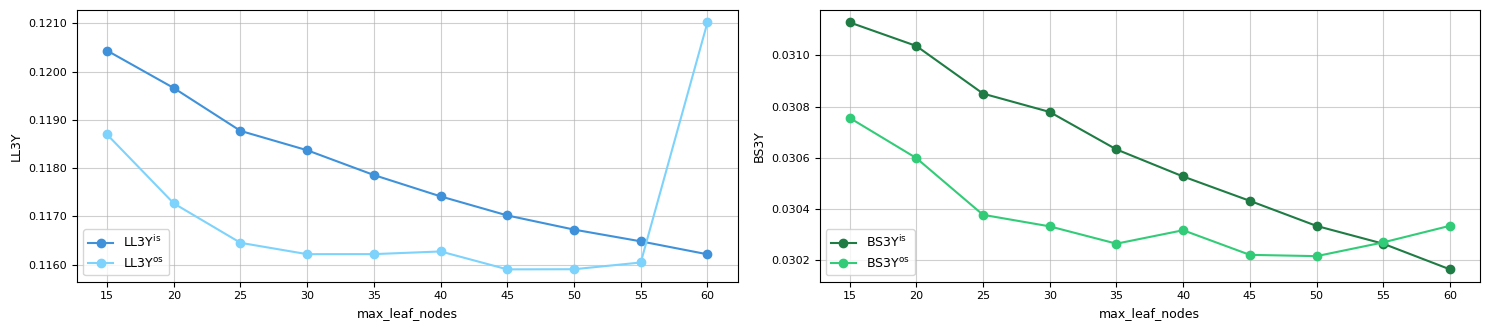

In [18]:
# define a function to format y-axis labels 
def format_4_decimals(x, pos):
    return f"{x:.4f}"

# ---plot---
fig, axes = plt.subplots(1, 2, figsize=(15, 3.4))

# ---log-loss plot---
axes[0].plot(max_leaf_nodess, ll_is_st3, marker='o', label=r'LL3Y$^{\text{is}}$', color='#3F92DA')
axes[0].plot(max_leaf_nodess, ll_os_st3, marker='o', label=r'LL3Y$^{\text{os}}$', color='#7DD3FC')
axes[0].set_xlabel("max_leaf_nodes", fontsize=9)
axes[0].set_ylabel("LL3Y", fontsize=9)
axes[0].legend(loc='lower left', fontsize=9)
axes[0].grid(True, alpha=0.6)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(format_4_decimals))  # Set y-axis to 4 decimal places
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(5))
axes[0].tick_params(axis='both', labelsize=8)

# ---Brier Score plot---
axes[1].plot(max_leaf_nodess, bs_is_st3, marker='o', label=r'BS3Y$^{\text{is}}$', color='#1E7C44')
axes[1].plot(max_leaf_nodess, bs_os_st3, marker='o', label=r'BS3Y$^{\text{os}}$', color='#32CC78')
axes[1].set_xlabel("max_leaf_nodes", fontsize=9)
axes[1].set_ylabel("BS3Y", fontsize=9)
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(True, alpha=0.6)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(format_4_decimals))  
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(5))
axes[1].tick_params(axis='both', labelsize=8)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.savefig(f'st3.png', format='png', dpi=300)
plt.show()

In [19]:
# fit
st3 = SurvivalTree(max_depth=7, max_leaf_nodes=50, min_samples_split=300)

start_time = time.time()
st3.fit(X_surv_train, y_surv_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 1.51 seconds


In [20]:
# predict survival function
surv_probs_train = st3.predict_survival_function(X_surv_train)
surv_probs_test = st3.predict_survival_function(X_surv_test)

# all time-to-event points
time_points_train = surv_probs_train[0].x
time_points_test = surv_probs_test[0].x 
 
# convert survival probabilities to df
df_surv_probs_train = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_train],  
    columns=time_points_train)
df_surv_probs_test = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_test],  
    columns=time_points_train)

# surv probabilites after 1 and 3 years
suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

# extract status
# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

# log-loss
log_loss_3y_train = log_loss(status_3y_train_surv, suvr_prob_3y_train)
log_loss_3y_test = log_loss(status_3y_test_surv, suvr_prob_3y_test)

# compute Brier
bs_train_3y = brier_score_loss(status_3y_train_surv, suvr_prob_3y_train)
bs_test_3y = brier_score_loss(status_3y_test_surv, suvr_prob_3y_test)

# c-index
c_is = concordance_index(status_3y_train_surv, suvr_prob_3y_train)

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1167
Log Loss os: 0.1159
BS is: 0.0303
BS os: 0.0302
C is: 0.8730


In [21]:
# ST4

In [22]:
max_depths = [5, 6, 7, 8, 9, 10, 11, 12]

ll_is_st4 = []
ll_os_st4 = []
bs_is_st4 = []
bs_os_st4 = []

status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

for max_depth in max_depths:
    model = SurvivalTree(max_depth=max_depth, max_leaf_nodes=50, min_samples_split = 300)
    model.fit(X_surv_train, y_surv_train)
    
    # get predicted probabilities
    surv_probs_train = model.predict_survival_function(X_surv_train)
    surv_probs_test = model.predict_survival_function(X_surv_test)
    # all time-to-event points
    time_points_train = surv_probs_train[0].x
    time_points_test = surv_probs_test[0].x 
    # convert survival probabilities to df
    df_surv_probs_train = pd.DataFrame(data=[fn(time_points_train) for fn in surv_probs_train],columns=time_points_train)
    df_surv_probs_test = pd.DataFrame(data=[fn(time_points_train) for fn in surv_probs_test], columns=time_points_train)
    # surv probabilites after 3 years
    suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
    suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

    # compute Log Loss
    ll_is_st4.append(log_loss(status_3y_train_surv, suvr_prob_3y_train))
    ll_os_st4.append(log_loss(status_3y_test_surv, suvr_prob_3y_test))
    # compute Brier
    bs_is_st4.append(brier_score_loss(status_3y_train_surv, suvr_prob_3y_train))
    bs_os_st4.append(brier_score_loss(status_3y_test_surv, suvr_prob_3y_test))

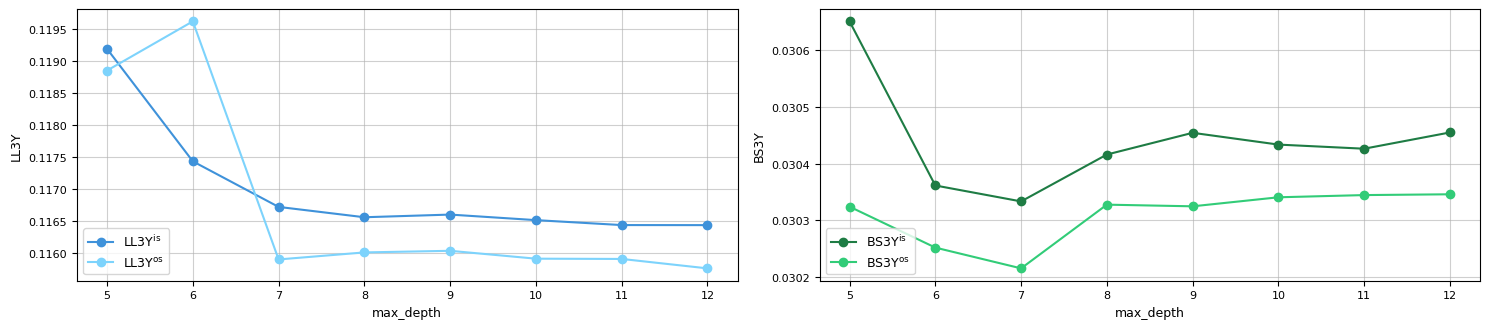

In [23]:
# define a function to format y-axis labels 
def format_4_decimals(x, pos):
    return f"{x:.4f}"

# ---plot---
fig, axes = plt.subplots(1, 2, figsize=(15, 3.4))

# ---log-Loss plot---
axes[0].plot(max_depths, ll_is_st4, marker='o', label=r'LL3Y$^{\text{is}}$', color='#3F92DA')
axes[0].plot(max_depths, ll_os_st4, marker='o', label=r'LL3Y$^{\text{os}}$', color='#7DD3FC')
axes[0].set_xlabel("max_depth", fontsize=9)
axes[0].set_ylabel("LL3Y", fontsize=9)
axes[0].legend(loc='lower left', fontsize=9)
axes[0].grid(True, alpha=0.6)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(format_4_decimals))  
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(1))
axes[0].tick_params(axis='both', labelsize=8)

# ---Brier Score plot---
axes[1].plot(max_depths, bs_is_st4, marker='o', label=r'BS3Y$^{\text{is}}$', color='#1E7C44')
axes[1].plot(max_depths, bs_os_st4, marker='o', label=r'BS3Y$^{\text{os}}$', color='#32CC78')
axes[1].set_xlabel("max_depth", fontsize=9)
axes[1].set_ylabel("BS3Y", fontsize=9)
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(True, alpha=0.6)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(format_4_decimals))  
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(1))
axes[1].tick_params(axis='both', labelsize=8)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.savefig(f'st4.png', format='png', dpi=300)
plt.show()

In [24]:
# fit
st4 = SurvivalTree(max_depth=7, max_leaf_nodes=50, min_samples_split=300)

start_time = time.time()
st4.fit(X_surv_train, y_surv_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 1.53 seconds


In [25]:
# predict survival function
surv_probs_train = st3.predict_survival_function(X_surv_train)
surv_probs_test = st3.predict_survival_function(X_surv_test)

# all time-to-event points
time_points_train = surv_probs_train[0].x
time_points_test = surv_probs_test[0].x 
 
# convert survival probabilities to df
df_surv_probs_train = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_train],  
    columns=time_points_train)
df_surv_probs_test = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_test],  
    columns=time_points_train)

# surv probabilites after 1 and 3 years
suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

# extract status
# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

# log-loss
log_loss_3y_train = log_loss(status_3y_train_surv, suvr_prob_3y_train)
log_loss_3y_test = log_loss(status_3y_test_surv, suvr_prob_3y_test)

# compute Brier
bs_train_3y = brier_score_loss(status_3y_train_surv, suvr_prob_3y_train)
bs_test_3y = brier_score_loss(status_3y_test_surv, suvr_prob_3y_test)

# c-index
c_is = concordance_index(status_3y_train_surv, suvr_prob_3y_train)

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1167
Log Loss os: 0.1159
BS is: 0.0303
BS os: 0.0302
C is: 0.8730


In [26]:
# ST5

In [27]:
min_samples_splits = [150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850]

ll_is_st5 = []
ll_os_st5 = []
bs_is_st5 = []
bs_os_st5 = []

status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

for min_samples_split in min_samples_splits:
    model = SurvivalTree(max_depth=7, max_leaf_nodes=50, min_samples_split=min_samples_split)
    model.fit(X_surv_train, y_surv_train)
    
    # get predicted probabilities
    surv_probs_train = model.predict_survival_function(X_surv_train)
    surv_probs_test = model.predict_survival_function(X_surv_test)
    # all time-to-event points
    time_points_train = surv_probs_train[0].x
    time_points_test = surv_probs_test[0].x 
    # convert survival probabilities to df
    df_surv_probs_train = pd.DataFrame(data=[fn(time_points_train) for fn in surv_probs_train],columns=time_points_train)
    df_surv_probs_test = pd.DataFrame(data=[fn(time_points_train) for fn in surv_probs_test], columns=time_points_train)
    # surv probabilites after 3 years
    suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
    suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

    # compute Log Loss
    ll_is_st5.append(log_loss(status_3y_train_surv, suvr_prob_3y_train))
    ll_os_st5.append(log_loss(status_3y_test_surv, suvr_prob_3y_test))
    # compute Brier
    bs_is_st5.append(brier_score_loss(status_3y_train_surv, suvr_prob_3y_train))
    bs_os_st5.append(brier_score_loss(status_3y_test_surv, suvr_prob_3y_test))

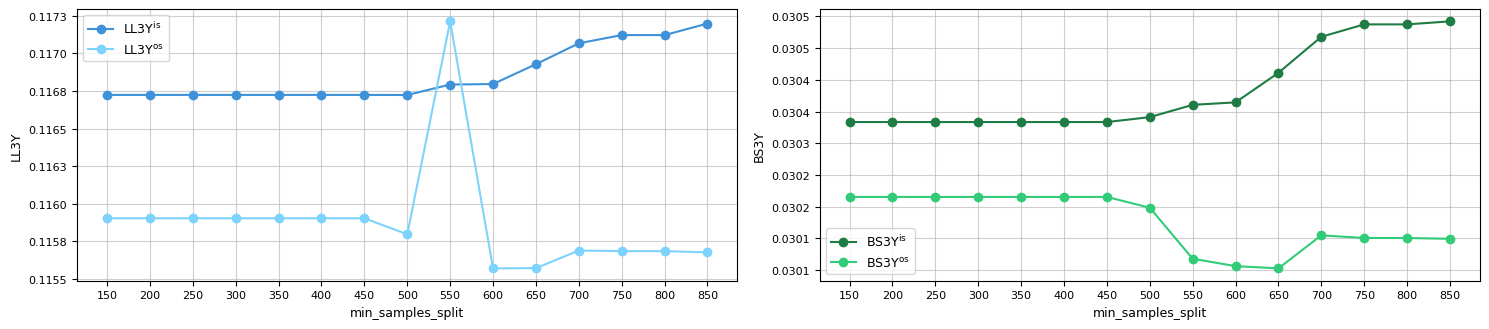

In [28]:
# define a function to format y-axis labels 
def format_4_decimals(x, pos):
    return f"{x:.4f}"

# ---plot---
fig, axes = plt.subplots(1, 2, figsize=(15, 3.4))

# ---log-Loss plot---
axes[0].plot(min_samples_splits, ll_is_st5, marker='o', label=r'LL3Y$^{\text{is}}$', color='#3F92DA')
axes[0].plot(min_samples_splits, ll_os_st5, marker='o', label=r'LL3Y$^{\text{os}}$', color='#7DD3FC')
axes[0].set_xlabel("min_samples_split", fontsize=9)
axes[0].set_ylabel("LL3Y", fontsize=9)
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.6)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(format_4_decimals)) 
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[0].tick_params(axis='both', labelsize=8)

# ---Brier Score plot---
axes[1].plot(min_samples_splits, bs_is_st5, marker='o', label=r'BS3Y$^{\text{is}}$', color='#1E7C44')
axes[1].plot(min_samples_splits, bs_os_st5, marker='o', label=r'BS3Y$^{\text{os}}$', color='#32CC78')
axes[1].set_xlabel("min_samples_split", fontsize=9)
axes[1].set_ylabel("BS3Y", fontsize=9)
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(True, alpha=0.6)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(format_4_decimals))  
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[1].tick_params(axis='both', labelsize=8)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.savefig(f'st5.png', format='png', dpi=300)
plt.show()

In [29]:
# fit
st5 = SurvivalTree(max_depth=7, max_leaf_nodes=50, min_samples_split=650)

start_time = time.time()
st5.fit(X_surv_train, y_surv_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 1.54 seconds


In [30]:
# predict survival function
surv_probs_train = st5.predict_survival_function(X_surv_train)
surv_probs_test = st5.predict_survival_function(X_surv_test)

# all time-to-event points
time_points_train = surv_probs_train[0].x
time_points_test = surv_probs_test[0].x 
 
# convert survival probabilities to df
df_surv_probs_train = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_train],  
    columns=time_points_train)
df_surv_probs_test = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_test],  
    columns=time_points_train)

# surv probabilites after 1 and 3 years
suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

# extract status
# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train_surv = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

# log-loss
log_loss_3y_train = log_loss(status_3y_train_surv, suvr_prob_3y_train)
log_loss_3y_test = log_loss(status_3y_test_surv, suvr_prob_3y_test)

# compute Brier
bs_train_3y = brier_score_loss(status_3y_train_surv, suvr_prob_3y_train)
bs_test_3y = brier_score_loss(status_3y_test_surv, suvr_prob_3y_test)

# c-index
c_is = concordance_index(status_3y_train_surv, suvr_prob_3y_train)

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1169
Log Loss os: 0.1156
BS is: 0.0304
BS os: 0.0301
C is: 0.8730
